In [1]:
import pandas as pd
import numpy as np
import pybedtools
pybedtools.helpers.set_tempdir('tmp')
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
import time


In [2]:
#import the atac patient metadata
MBC_pt_data_path = '../raw_TCGA/sample_info.txt'
pt_data = pd.read_csv(MBC_pt_data_path, sep='\t')

#get only breast cancer data and keep only the sample name and subtype
pt_data = pt_data[pt_data['cohort']=='BRCA'][['submitter_id','BRCA_scmod2']]

#drop samples with replicates
pt_data = pt_data.drop_duplicates()
print('total_brca_patient_samples',len(pt_data))

#drop samples without subtype
pt_data = pt_data[~(pt_data['BRCA_scmod2'].isnull())]
print('patient samples with subtype info',len(pt_data),'\n')

#get list of ER positive samples
ER_pos = pt_data[(pt_data['BRCA_scmod2'].str.contains('ER\+'))]#'ER\+' is necessary so that this isn't a regex expression meaning something else

#print the subtypes for these samples (there are multiple subtypes within ER positive)
print('ER_pos',ER_pos['BRCA_scmod2'].unique())

#get just the pt ids
ER_pos = ER_pos['submitter_id'].values
print('ER+',len(ER_pos),'\n')

#repeat for ER negative
ER_neg = pt_data[pt_data['BRCA_scmod2'].str.contains('ER-')]
print('ER_neg',ER_neg['BRCA_scmod2'].unique())

#get just the pt ids
ER_neg = ER_neg['submitter_id'].values
print('ER-',len(ER_neg),'\n')

#sanity check, get the samples that are neither ER+ nor ER-
ER_other = pt_data[~(pt_data['BRCA_scmod2'].str.contains('ER\+')) & ~(pt_data['BRCA_scmod2'].str.contains('ER-'))]#'ER\+' is necessary so that this isn't a regex expression meaning something else
print('other',ER_other['BRCA_scmod2'].unique())
print('other', len(ER_other))

total_brca_patient_samples 74
patient samples with subtype info 70 

ER_pos ['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif']
ER+ 44 

ER_neg ['ER-/HER2-']
ER- 15 

other ['HER2+']
other 11


In [3]:
chroms = ['chr'+str(m) for m in range(1,23)]

In [4]:
#peak data for each sample
MBC_peak_data_path = '../raw_TCGA/brca_peak_Log2Counts_dedup.txt'
peak_data = pd.read_csv(MBC_peak_data_path,sep='\t')

#remove '-01A' from sample names in columns
peak_data.columns = [item.split('-01A')[0] for item in peak_data.columns]
peak_data.columns = [item.split('-01B')[0] for item in peak_data.columns]

peak_data = peak_data.rename(columns = {'sample':'peak_name'}).set_index('peak_name')

In [5]:
#peak locations
MBC_peak_loc_path = '../filtered_sites/sites/all_brca_peaks.high_mapability.txt'
MBC_peak_loc = pd.read_csv(MBC_peak_loc_path, sep='\t')
print(len(MBC_peak_loc))
MBC_peak_loc = MBC_peak_loc.rename(columns = {'Chromosome':'Chrom'})

#drop any sites on the x chromosome or non-standard chromosomes
MBC_peak_loc = MBC_peak_loc[MBC_peak_loc['Chrom'].isin(chroms)]
print(len(MBC_peak_loc))
# MBC_peak_bed = pybedtools.BedTool.from_dataframe(MBC_peak_loc[['Chrom','Start','End']])
# MBC_peak_bed.sort()
# MBC_peak_loc.head()

144960
142490


In [6]:
#Find ER +/- specific peaks
#merge in the patient values
peaks_with_pt_values = MBC_peak_loc.merge(peak_data[list(ER_pos)+list(ER_neg)], left_on = 'Peak_Name', right_index=True)
print(len(peaks_with_pt_values))

#run statistical tests
p_vals = []
start_time = time.time()
for i in range(len(peaks_with_pt_values)):
    if i%10000==0:
        print(i, time.time()-start_time)
    current = peaks_with_pt_values.iloc[i]
    p_val = mannwhitneyu(current[ER_pos],current[ER_neg], alternative = 'two-sided')[1]
    p_vals.append(p_val)
    
peaks_with_pt_values['mannwhitneyu_p']= p_vals

peaks_with_pt_values['ER_pos_median'] = peaks_with_pt_values[ER_pos].median(axis=1)
peaks_with_pt_values['ER_neg_median'] = peaks_with_pt_values[ER_neg].median(axis=1)

#drop the patient values so they aren't all exported
peaks_with_pt_values = peaks_with_pt_values.drop(columns = ER_pos)
peaks_with_pt_values = peaks_with_pt_values.drop(columns = ER_neg)

print(len(peaks_with_pt_values))

142490
0 0.00011324882507324219
10000 10.72724437713623
20000 21.497912883758545
30000 32.30589771270752
40000 43.06868386268616
50000 53.91770362854004
60000 64.73379063606262
70000 75.53659892082214
80000 86.29955959320068
90000 97.14161920547485
100000 107.96513819694519
110000 118.73099374771118
120000 129.5491943359375
130000 140.40017867088318
140000 151.21827936172485
142490


In [7]:
#do a multiple test correction using the Benjamini/Hochberg fdr correction
from statsmodels.stats.multitest import multipletests

reject,pvals_corrected,alphacSidak,alphacBonf=multipletests(peaks_with_pt_values['mannwhitneyu_p'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

peaks_with_pt_values['mw_FDR']=pvals_corrected

peaks_with_pt_values['neg_log2_mw_FDR'] = -np.log2(peaks_with_pt_values['mw_FDR'])

#calculate fold change (subtract because these are logged values)
peaks_with_pt_values['log2_FC'] = peaks_with_pt_values['ER_pos_median']-peaks_with_pt_values['ER_neg_median']

In [8]:
#export
peaks_with_pt_values.to_csv('sites/all_mbc_with_score.txt', sep='\t', index=False)

In [9]:
hem_peak_loc_path = '../../hematopoietic/sites_hg38/GSE129785_scATAC-Hematopoiesis-All.peaks_hg38.bed'
hem_peak_loc = pd.read_csv(hem_peak_loc_path, sep='\t', header=None)

#drop any sites on the x chromosome or non-standard chromosomes
hem_peak_loc = hem_peak_loc[hem_peak_loc[0].isin(chroms)]

#discard 1272 peaks that change size during liftover
hem_peak_loc['width'] = hem_peak_loc[2]-hem_peak_loc[1]
print('discarding wrong length:',len(hem_peak_loc) - len(hem_peak_loc[hem_peak_loc['width']==500]))
hem_peak_loc = hem_peak_loc[hem_peak_loc['width']==500]

heme_peak_bed = pybedtools.BedTool.from_dataframe(hem_peak_loc[[0,1,2]])
heme_peak_bed.sort()
print(len(hem_peak_loc))
hem_peak_loc.head()


discarding wrong length: 1140
555525


,0,1,2,width
0,chr1,10238,10738,500
1,chr1,115476,115976,500
2,chr1,267105,267605,500
3,chr1,267760,268260,500
4,chr1,271050,271550,500


In [10]:
#covert to a bed for overlapping
MBC_peak_bed = pybedtools.BedTool.from_dataframe(peaks_with_pt_values[['Chrom','Start','End']])

In [11]:
#split MBC peaks by whether they overlap heme
mbc_specific = MBC_peak_bed.subtract(heme_peak_bed, A=True)
mbc_overlaps = MBC_peak_bed.intersect(heme_peak_bed, u=True)

print('specific', len(mbc_specific))
print('overlaps', len(mbc_overlaps))

print('total', len(mbc_specific)+len(mbc_overlaps))

specific 64219
overlaps 78271
total 142490


In [12]:
#get the peak data
mbc_specific_df = mbc_specific.to_dataframe().rename(columns = {'chrom':'Chrom','start':'Start','end':'End'})
mbc_specific_df = mbc_specific_df.merge(peaks_with_pt_values, on = ['Chrom','Start','End'])
print('specific',len(mbc_specific_df))


#get the peak data
mbc_overlaps_df = mbc_overlaps.to_dataframe().rename(columns = {'chrom':'Chrom','start':'Start','end':'End'})
mbc_overlaps_df = mbc_overlaps_df.merge(peaks_with_pt_values, on = ['Chrom','Start','End'])
print('overlaps',len(mbc_overlaps_df))

specific 64219
overlaps 78271


In [13]:
# #export the full lists (to make plotting easier if needed)
# mbc_overlaps_df.to_csv('sites/all_mbc_heme_overlaps_with_score.txt', sep='\t', index=False)
# mbc_specific_df.to_csv('sites/all_mbc_specific_with_score.txt', sep='\t', index=False)

In [14]:
fold_change = 0.5
fc_string = '_'.join(str(fold_change).split('.'))

positive_specific = mbc_specific_df[(mbc_specific_df['mw_FDR']<0.05) & (mbc_specific_df['log2_FC']>fold_change)]
negative_specific = mbc_specific_df[(mbc_specific_df['mw_FDR']<0.05) & (mbc_specific_df['log2_FC']<-fold_change)]

positive_overlaps = mbc_overlaps_df[(mbc_overlaps_df['mw_FDR']<0.05) & (mbc_overlaps_df['log2_FC']>fold_change)]
negative_overlaps = mbc_overlaps_df[(mbc_overlaps_df['mw_FDR']<0.05) & (mbc_overlaps_df['log2_FC']<-fold_change)]

print('positive_specific:',len(positive_specific))
print('negative_specific:',len(negative_specific))

print('positive_overlaps:',len(positive_overlaps))
print('negative_overlaps:',len(negative_overlaps))


positive_specific: 15142
negative_specific: 12151
positive_overlaps: 12217
negative_overlaps: 12710


In [3]:
142490-(15142+12151+12217+12710)

90270

In [1]:
15142+12217

27359

In [2]:
12151+12710

24861

In [15]:
#export
positive_specific.to_csv('sites/ER_pos_0_5_FC.new.txt', sep='\t',index=False)
negative_specific.to_csv('sites/ER_neg_0_5_FC.new.txt', sep='\t',index=False)

positive_overlaps.to_csv('sites/ER_pos_heme_0_5_FC.new.txt', sep='\t',index=False)
negative_overlaps.to_csv('sites/ER_neg_heme_0_5_FC.new.txt', sep='\t',index=False)


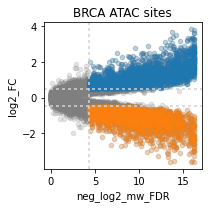

In [16]:
#global figure
fig,ax= plt.subplots(figsize = (3,3))
sample_set = peaks_with_pt_values.sample(frac = .1, random_state =2).copy()

#this looks different from Hanna's because I'm using FDR on the x axis rather than p-value
sample_set.plot.scatter(x = 'neg_log2_mw_FDR',y='log2_FC', alpha = 0.2, ax=ax, color='tab:grey')
sample_set[(sample_set['mw_FDR']<0.05) & (sample_set['log2_FC']>fold_change)].plot.scatter(x = 'neg_log2_mw_FDR',y='log2_FC', alpha = 0.2, ax=ax, color='tab:blue')
sample_set[(sample_set['mw_FDR']<0.05) & (sample_set['log2_FC']<-fold_change)].plot.scatter(x = 'neg_log2_mw_FDR',y='log2_FC', alpha = 0.2, ax=ax, color='tab:orange')

ax.axvline(x=-np.log2(0.05), color='lightgrey',dashes=(2,2))
ax.axhline(y=-fold_change, color='lightgrey',dashes=(2,2))
ax.axhline(y=fold_change, color='lightgrey',dashes=(2,2))
ax.set_title('BRCA ATAC sites')
fig.tight_layout()
fig.savefig('butterfly_plot.pdf')